# Experiment 3. Apply MLReal to both inputs and regression targets
 
This notebook accompanies an experiment for low-frequency extrapolation using MLReal approach from [Alkhalifah, Wang and Ovcharenko, 2021](https://arxiv.org/abs/2109.05294). 
 The [network](https://github.com/ovcharenkoo/mtl_low) learns mapping between high-frequency data (> 4 Hz) and low-frequency data (< 5 Hz) where **both synthetic and field data inputs** are transformed using MLReal. 
In this example we provide **a backward method** to revert the forward MLReal transform.

**Note:** An application of MLReal to **regression targets** might be challenging since the method assumes data from both source and destination datasets available. 

**Takeaway:** Assuming that the training partition of target data from field dataset is available we apply MLReal for both inputs and outputs to get better results on test partition of field data.

In [1]:
# Most imports are in the shared_data_loading.ipynb
import os

# This is to prevent the error "this loop already running when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Constrain visibility of GPUs by selected one. This is to enable training of multiple networks each on its own device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Where to save the trained model
root_pretrained = os.path.join('./pretrained_files/trained_nets/ex3_mlreal_forw_back/')
root_out = root_pretrained

## Load data

1.8.1+cu102
3.8.3 (default, Oct 11 2020, 17:10:44) 
[GCC 7.5.0]
/home/ovcharoo/work/env_torch
{'high': {'flo': 4, 'btype': 'high', 'order': 8}, 'low': {'fhi': 5, 'btype': 'low', 'order': 8}, 'ulow': {'fhi': 2.5, 'btype': 'low', 'order': 8}}


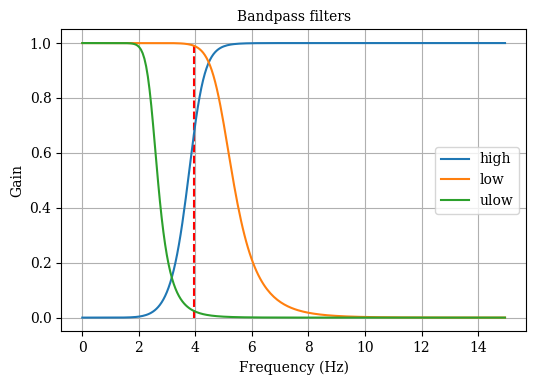

Load cubes from ./pretrained_files/data/syn_1024_el/...
(2765, 324, 376) (2765, 324, 376) (2765, 324, 376) (2765, 324, 376)
(154, 324, 376) (154, 324, 376) (154, 324, 376) (154, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
Processed data loaders: 2765 154
Load ./pretrained_files/data/noise_donors/cube_dst_te_h.npy
(80, 324, 376)
(80, 324, 446)
8


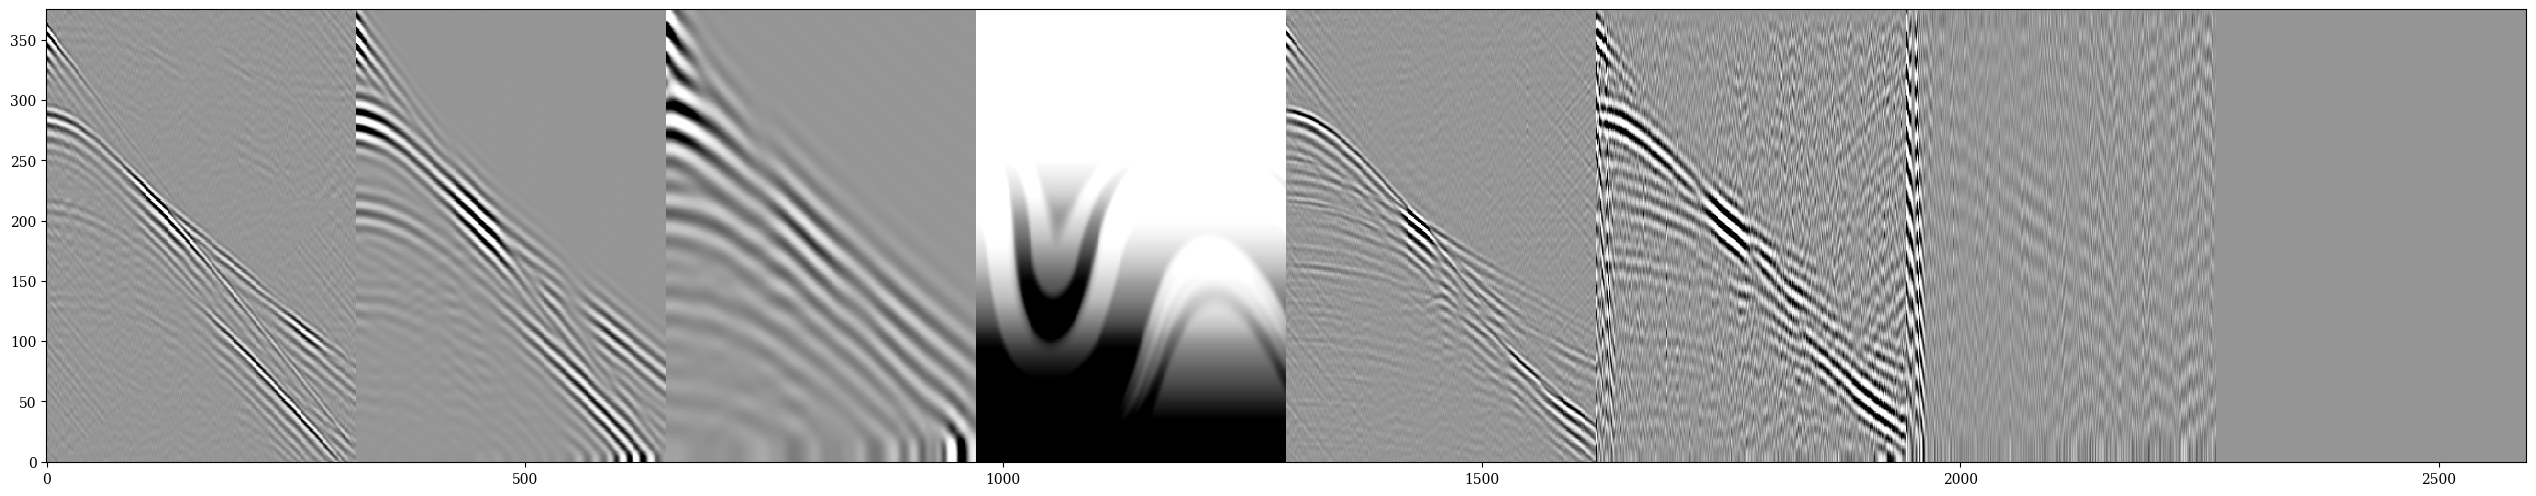

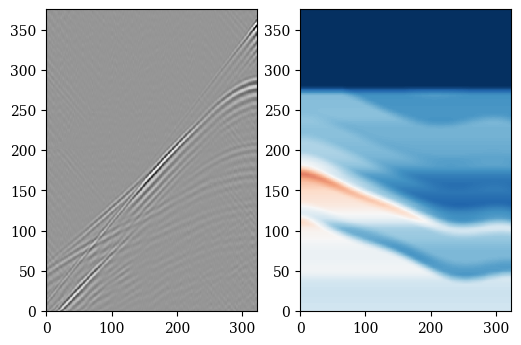

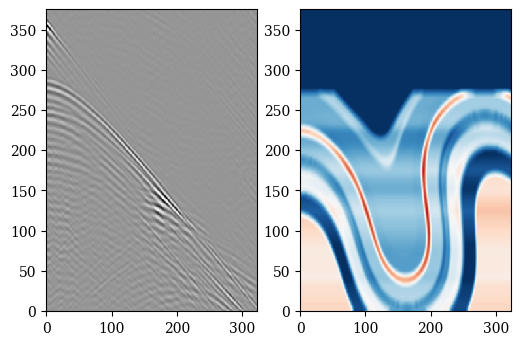

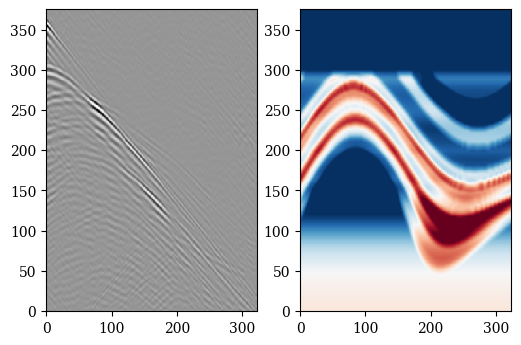

In [4]:
%run shared_data_loading.ipynb

# MLReal
This section implements **forward** and **backward** transformations

In [5]:
def forward(data, trace, glob_acorr):
    """Forward MLReal
    
    Args: 
        data(np.ndarray): [..., noffset, ntime], seismic shot gather
        trace(np.ndarray): [1, ntime], trace to convolve with
        glob_acorr(np.ndarray): mean auto-correlation of another dataset
    """
    # Data for xcorr with trace
    y = np.squeeze(data)
    ffty = np.fft.fftshift(np.fft.rfft(y, n=y.shape[-1], axis=1))

    # Trace
    no, nt = y.shape
    _trace = np.repeat(trace, no, 0)
    fft_trace = np.fft.fftshift(np.fft.rfft(_trace, n=_trace.shape[-1], axis=-1))

    # xcorr data and trace
    xcorr = ffty * np.conjugate(fft_trace)

    # Convolution of acorr and xcorr data
    conv = xcorr * glob_acorr

    # Freq -> time domain
    rr = np.fft.irfft(np.fft.ifftshift(conv), axis=-1)
    return np.expand_dims(rr, 0).astype(np.float32)

def backward(data, trace, glob_acorr, eps=1e0):
    """Reverse MLReal
    
    Args: 
        data(np.ndarray): [..., noffset, ntime], seismic shot gather
        trace(np.ndarray): [1, ntime], trace to convolve with
        glob_acorr(np.ndarray): mean auto-correlation of another dataset
    """
    # Data for xcorr with trace
    y = np.squeeze(data)
    ffty = np.fft.fftshift(np.fft.rfft(y, n=y.shape[-1], axis=-1))

    # Trace
    no, nt = y.shape
    _trace = np.repeat(trace, no, 0)
    fft_trace = np.fft.fftshift(np.fft.rfft(_trace, n=_trace.shape[-1], axis=-1))
    
    # Regularized deconvolution
    deconv =  (ffty * np.conjugate(glob_acorr)) / (glob_acorr * np.conjugate(glob_acorr) + eps)
    out = (fft_trace * deconv) / (fft_trace * np.conjugate(fft_trace) + eps)

    # Freq -> time domain
    rr = np.fft.irfft(np.fft.ifftshift(out), axis=-1)
    return np.expand_dims(rr, 0).astype(np.float32)

## Train loader
During the training stage, for each unmodified sample from synthetic training dataset we draw a random sample from field dataset.

In [6]:
class CorrLoader(torch.utils.data.Dataset):
    def __init__(self, l1, rcorr_indices=None, acorr_indices=None, reference_traces=None):
        """
        l1: original data loader
        rcorr_indices: indices in the output tuple of l1 for cross-correlation
        acorr_indices: indices in the output tuple of l1 for auto-correlation
        reference_traces: 
        """
        super().__init__()
        self.l1 = l1
        self.acorr_indices = acorr_indices
        self.rcorr_indices = rcorr_indices
        self.reference_traces = reference_traces
            
    def __len__(self):
        return len(self.l1)
        
    def __getitem__(self, item):
        list_data = list(self.l1.__getitem__(item))
        
        # Draw another random sample from the same data loader
        random_index = np.random.randint(0, len(self.l1))
        another_list_data = list(self.l1.__getitem__(random_index))
        
        for i in range(len(self.acorr_indices)):
            # Get auto-correlation on data from another sample
            x = np.squeeze(another_list_data[self.acorr_indices[i]])
            fftx = np.fft.fftshift(np.fft.rfft(x, n=x.shape[-1], axis=-1))
            acorr = fftx * np.conjugate(fftx)
            
            # Apply forward MLReal transform where auto-correlation of random sample describes
            # field dataset. At the inference stage we use mean of all auto-correlations
            rr = forward(list_data[self.rcorr_indices[i]], 
                         **{'trace': self.reference_traces[i], 'glob_acorr': acorr})
            
            # Append the transformed data to the end of the data vector
            list_data.append(rr)
        return list_data
  

In [7]:
idx = 600
# Take a trace from synthetic high-frequency data (index 0)
reference_trace = jloader_te.__getitem__(idx)[0][0, 4:5, :]
# From synthetic low-frequency data (index 1)
reference_trace_target = jloader_te.__getitem__(idx)[1][0, 4:5, :]

# From field high-frequency data (index 4)
reference_trace_f = jloader_te.__getitem__(idx)[4][0, 4:5, :]
# From field low-frequency data (index 5)
reference_trace_target_f = jloader_te.__getitem__(idx)[5][0, 4:5, :]

# # Plot traces
# vis.plot_signal([reference_trace, reference_trace_f], legend=['Syn', 'Field'])
# vis.plot_signal([reference_trace_target, reference_trace_target_f], legend=['Syn', 'Field'])

In [8]:
par_loader_corr = {'reference_traces': [reference_trace, reference_trace_target], 
                   'rcorr_indices': [0, 1], # select data: high and low synthetic
                   'acorr_indices': [4, 5]} # select data: high and low field

cloader_tr = CorrLoader(jloader_tr, **par_loader_corr)

## Test loader

In [9]:
class CorrLoaderTest(torch.utils.data.Dataset):
    def __init__(self, l1, rcorr_indices, acorr_indices, reference_traces, glob_acorr):
        """
        l1: original data loader
        rcorr_indices: indices in the output tuple of l1 for cross-correlation
        acorr_indices: indices in the output tuple of l1 for auto-correlation
        reference_traces: 
        glob_acorr: mean auto-correlation of another dataset
        """
        super().__init__()
        self.l1 = l1
        self.acorr_indices = acorr_indices
        self.rcorr_indices = rcorr_indices
        self.reference_traces = reference_traces
        self.glob_acorr = glob_acorr
            
    def __len__(self):
        return len(self.l1)
        
    def __getitem__(self, item):
        list_data = list(self.l1.__getitem__(item))
        
        for i in range(len(self.acorr_indices)):   
            rr = forward(list_data[self.rcorr_indices[i]], 
                         **{'trace': self.reference_traces[i], 
                          'glob_acorr': self.glob_acorr[i]})
            
            # Append the transformed data to the end of the data vector
            list_data.append(rr)

        return list_data

### Global auto-correlation

In [10]:
def get_global_acorr_for_loader(loader, index):
    """ The average auto-correlation of all images in the dataset """
    global_acorr = np.zeros((1,324,189), dtype=np.complex128)
    len_loader = len(loader)
    for idata in range(len_loader):
        print(f'{idata+1}/{len_loader}', end='\r')
        data = loader.__getitem__(idata)
        data_f = np.fft.fftshift(np.fft.rfft(data[index], n=data[index].shape[-1], axis=-1))
        
        # Auto-correlation is multiplication with the conjucate of self in frequency domain
        global_acorr += data_f * np.conjugate(data_f)
    global_acorr /= len_loader
    print(global_acorr.shape)
    return np.squeeze(global_acorr)

def route_to(fname):
    """ Shortcut for routing to the save folder """
    return os.path.join(root_out, fname)

### Save static data

In [11]:
# Compute global acorr if not in the folder, load otherwise
os.makedirs(root_out, exist_ok=True)
if not 'gacorr_hi.npy' in os.listdir(root_out):
    print('Save global acorr')
    gacorr_hi = get_global_acorr_for_loader(jloader_tr, index=0)
    gacorr_lo = get_global_acorr_for_loader(jloader_tr, index=1)
    gacorr_hi_f = get_global_acorr_for_loader(jloader_tr, index=4)
    gacorr_lo_f = get_global_acorr_for_loader(jloader_tr, index=5)
    np.save(route_to('gacorr_hi.npy'), gacorr_hi)
    np.save(route_to('gacorr_lo.npy'), gacorr_lo)
    np.save(route_to('gacorr_hi_f.npy'), gacorr_hi_f)
    np.save(route_to('gacorr_lo_f.npy'), gacorr_lo_f)
else:
    print('Load global acorr')
    gacorr_hi = np.load(route_to('gacorr_hi.npy'))
    gacorr_lo = np.load(route_to('gacorr_lo.npy'))
    gacorr_hi_f = np.load(route_to('gacorr_hi_f.npy'))
    gacorr_lo_f = np.load(route_to('gacorr_lo_f.npy'))

Load global acorr


### Init train and test dataloaders

In [12]:
cloader_te = CorrLoaderTest(jloader_te, 
                           reference_traces=[reference_trace, reference_trace_target],
                           rcorr_indices=[0, 1],
                           acorr_indices=[4, 5],
                           glob_acorr=[gacorr_hi_f, gacorr_lo_f])
cloader_te_f = CorrLoaderTest(jloader_te, 
                        reference_traces=[reference_trace_f, reference_trace_target_f], 
                        rcorr_indices=[4, 5],  # high and low field
                        acorr_indices=[0, 1],
                        glob_acorr=[gacorr_hi, gacorr_lo])  

## Explore data

In [13]:
idx = 41
# Original loader
d = jloader_te.__getitem__(idx)
# Training loader (synthetic data normalized)
dc = cloader_te.__getitem__(idx)
# Inference loader (field data normalized)
df = cloader_te_f.__getitem__(idx)

### Synthetic

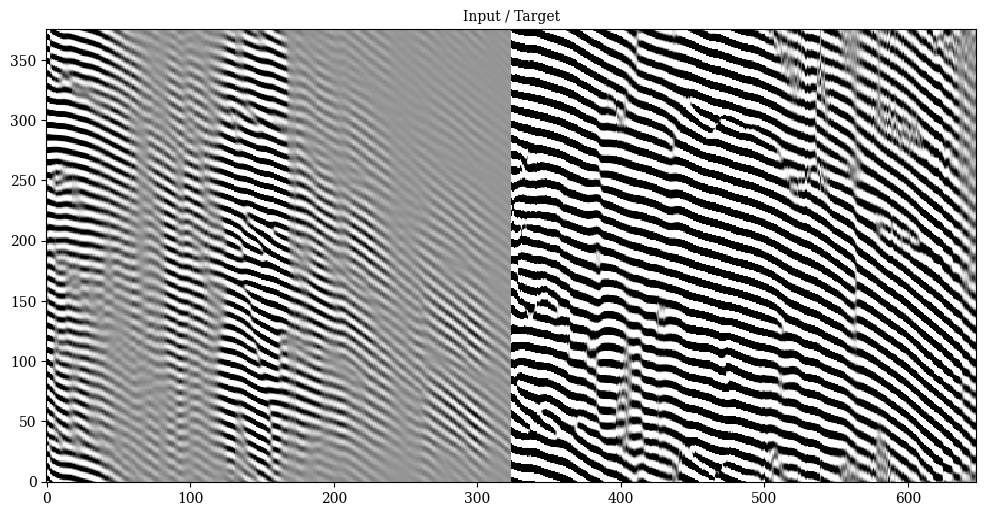

In [14]:
par_shot_auto = {'vmax': 0.25, 'vmin': -0.25, 'figsize': (24,6), 'colorbar': False}
_par_shot_auto = copy.copy(par_shot_auto)
_par_shot_auto['figsize'] = (12, 6)
_par_shot_auto_norm = copy.copy(_par_shot_auto)
_par_shot_auto_norm['vmin'] = -2.5
_par_shot_auto_norm['vmax'] = 2.5

# Input is pre-last, target is last
vis.plot_shot(np.concatenate([dc[i][0,...] for i in [-2, -1]]), **_par_shot_auto_norm, title='Input / Target')
# plt.figure(); plt.plot(reference_trace.T, color='k'); plt.title('Reference trace from high-frequency synthetic');

### backward(forward(data))

(1, 324, 376) (1, 324, 376)


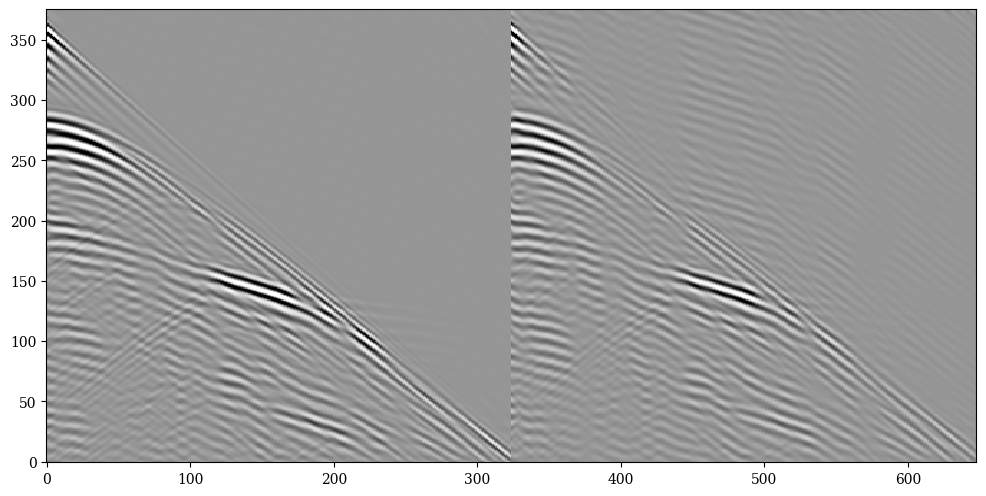

In [15]:
par_forw_back_h = {'trace': reference_trace, 
                 'glob_acorr': gacorr_hi_f}

dc_h_inv = backward(forward(d[0], **par_forw_back_h), **par_forw_back_h) 
print(d[0].shape, dc_h_inv.shape)
vis.plot_shot(np.concatenate([np.squeeze(d[0]), np.squeeze(dc_h_inv)], 0), **_par_shot_auto)

### Field

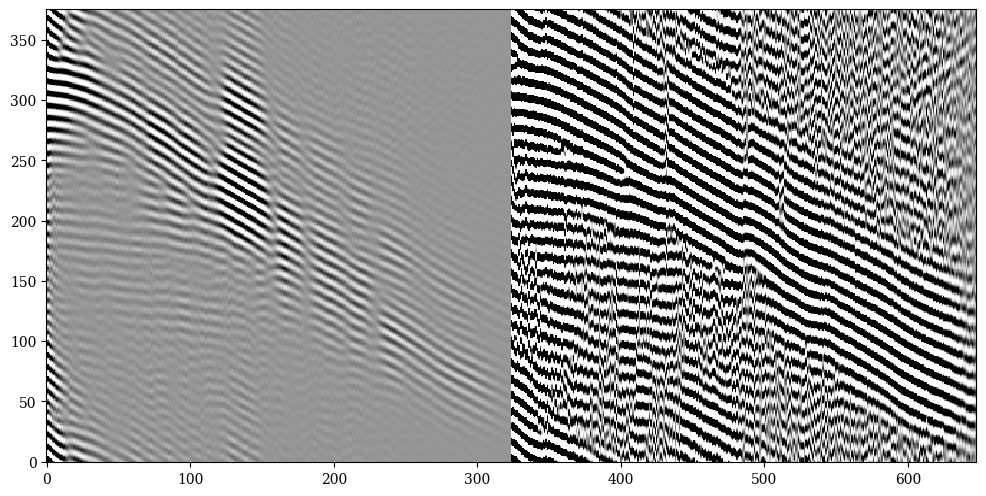

In [16]:
vis.plot_shot(np.concatenate([df[i][0,...] for i in [-2, -1]]), **_par_shot_auto_norm)
# plt.figure(); plt.plot(reference_trace_f.T, color='k'); plt.title('Reference trace from high-frequency synthetic');

### High-frequencies reverse

52.314766
(1, 324, 376): 0.7679476737976074 --> 52.31476593017578 --> 0.44394034147262573


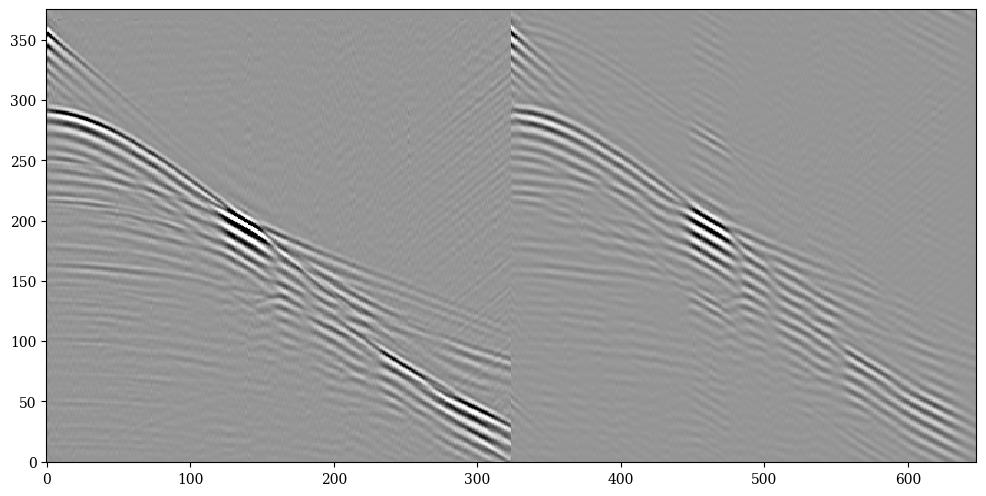

In [17]:
def plot_forw_back(d, par):
    d_forw = forward(d, **par)
    print(d_forw.max())
    d_back = backward(d_forw, **par) 
    print('{}: {} --> {} --> {}'.format(d.shape, d.max(), d_forw.max(), d_back.max()))
    vis.plot_shot(np.concatenate([np.squeeze(d), np.squeeze(d_back)], 0), **_par_shot_auto)

plot_forw_back(df[4], {'trace': reference_trace_f, 'glob_acorr': gacorr_hi})

### Low-frequencies reverse

1007.1773
(1, 324, 376): 1.0 --> 1007.1773071289062 --> 0.8175575137138367


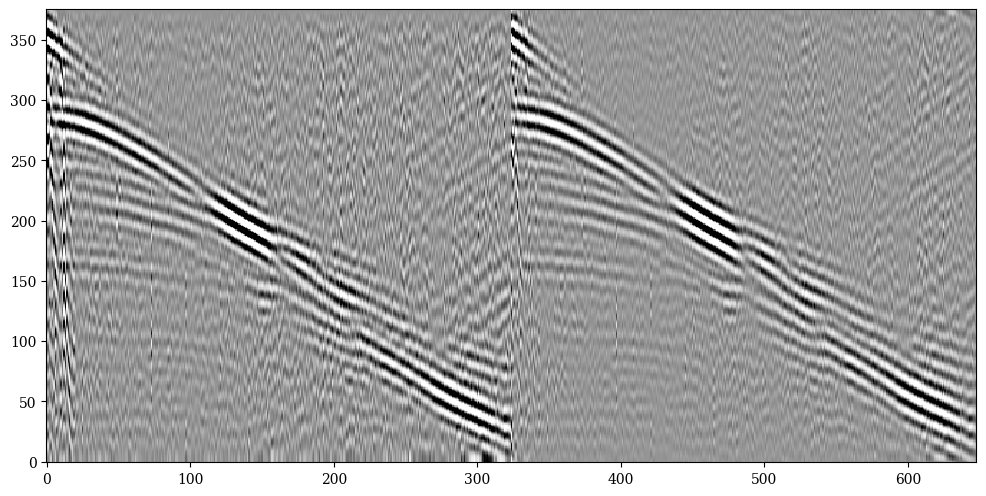

In [18]:
plot_forw_back(df[5], {'trace': reference_trace_target_f, 'glob_acorr': gacorr_lo})

## Syn VS Field

Input before RMS:	[0.04274155101897403, 0.04107810967665637]
Input after RMS:	[3.016962242092659, 1.1906231934683877]
Target before RMS:	[0.07554600545604165, 0.08275974693024492]
Target after RMS:	[56.692076998742166, 28.26682269088777]


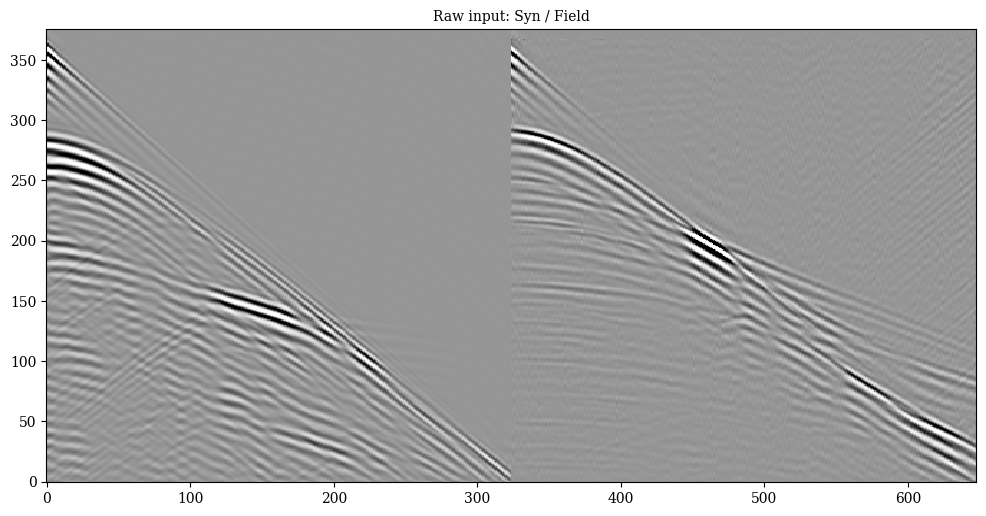

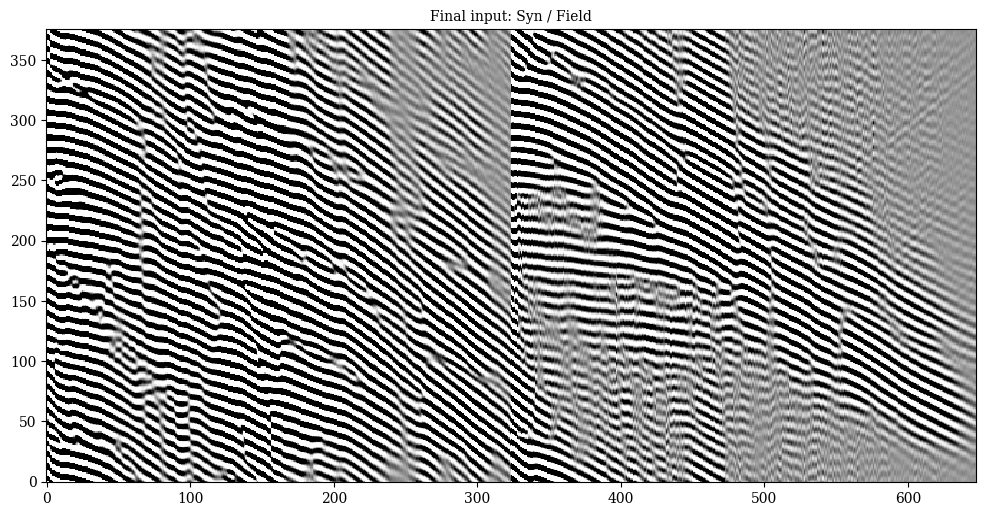

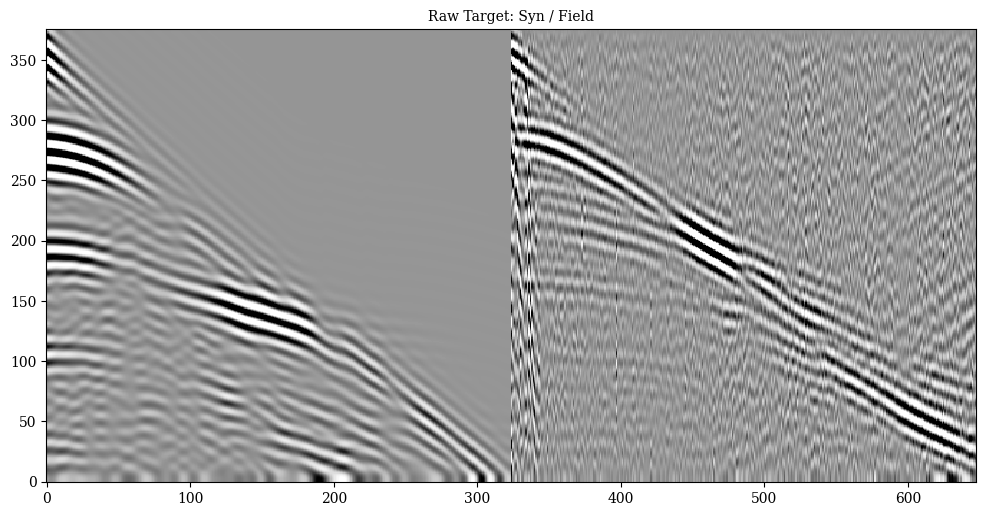

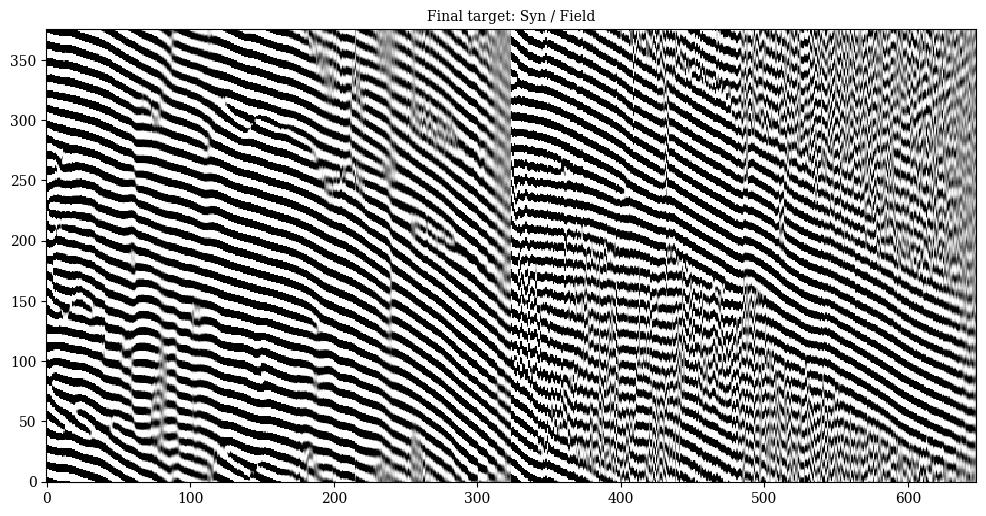

In [19]:
datas = [d[0], d[4]]
print(f'Input before RMS:\t{[vis.rms(_d) for _d in datas]}')
vis.plot_shot(np.concatenate([_d[0,...] for _d in datas]), title='Raw input: Syn / Field', **_par_shot_auto)

datas = [dc[-2], df[-2]]
print(f'Input after RMS:\t{[vis.rms(_d) for _d in datas]}')
vis.plot_shot(np.concatenate([_d[0,...] for _d in datas]), title='Final input: Syn / Field', **_par_shot_auto)

datas = [d[1], d[5]]
print(f'Target before RMS:\t{[vis.rms(_d) for _d in datas]}')
vis.plot_shot(np.concatenate([_d[0,...] for _d in datas]), title='Raw Target: Syn / Field', **_par_shot_auto)

datas = [dc[-1], df[-1]]
print(f'Target after RMS:\t{[vis.rms(_d) for _d in datas]}')
vis.plot_shot(np.concatenate([_d[0,...] for _d in datas]), title='Final target: Syn / Field', **_par_shot_auto_norm)

# Multi-column architecture
Based on https://github.com/shepnerd/inpainting_gmcnn

In [20]:
# Import architectures
# from utils.archs import HeadData, Encoder
# summary(Encoder(1).to(0), (1, 324, 376))

In [21]:
# summary(HeadData(layers=[(96, 32), (32, 16)],
#              layers_out=(16, 1),
#              kernel_sizes=[4, 4], 
#              strides=[2, 2], 
#              pads=[1, 1]).to(0), (96, 81, 94))

In [22]:
# Low-frequency data head (L)
import torch.nn as nn

class HeadData(nn.Module):
    def __init__(self, layers, layers_out, kernel_sizes, strides, pads):
        super().__init__()
        self.act = F.leaky_relu
        self.decoding_layers = []
        
        # Upscale to the target size
        for ilayer, (ch_inp, ch_out) in enumerate(layers):
            self.decoding_layers.append(nn.ConvTranspose2d(ch_inp, ch_out, 
                                                            kernel_size=kernel_sizes[ilayer], 
                                                            stride=strides[ilayer],
                                                            padding=pads[ilayer]))
            self.decoding_layers.append(nn.LeakyReLU())
        
        # After reaching the target size, do this
        self.out_layers = []
        self.out_layers.append(nn.Conv2d(layers_out[0], layers_out[0], kernel_size=3, padding=1))
        self.out_layers.append(nn.Conv2d(layers_out[0], layers_out[1],kernel_size=1))
        
        # Convert to Pytorch modules
        self.decoding_layers = nn.ModuleList(self.decoding_layers)
        self.out_layers = nn.ModuleList(self.out_layers)
        
    def forward(self, x):
        for layer in self.decoding_layers:
            x = layer(x)
        for layer in self.out_layers:
            x = layer(x)
        return x #torch.clip(x, -1, 1)

# Encoder
# Based on https://github.com/shepnerd/inpainting_gmcnn
class Encoder(nn.Module):
    def __init__(self, n_channels, kernel_size=3, bilinear=True, s=2, ch=8):
        super().__init__()
        self.using_norm = True
        self.norm = F.instance_norm
        self.act = F.leaky_relu
        
        # network structure
        self.EB1 = []
        self.EB1_pad_rec = [3, 3, 3, 3, 3, 3, 6, 12, 24, 48, 3, 3, 0]
        self.EB1.append(nn.Conv2d(n_channels, ch, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch, ch * 2, kernel_size=7, stride=2))
        self.EB1.append(nn.Conv2d(ch * 2, ch * 2, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch * 2, ch * 4, kernel_size=7, stride=2))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1, dilation=2))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1, dilation=4))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1, dilation=8))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1, dilation=16))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1))
        self.EB1 = nn.ModuleList(self.EB1)
        
        self.EB2 = []
        self.EB2_pad_rec = [2, 2, 2, 2, 2, 2, 4, 8, 16, 32, 2, 2, 0, 2, 2, 0]
        self.EB2.append(nn.Conv2d(n_channels, ch, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch, ch * 2, kernel_size=5, stride=2))
        self.EB2.append(nn.Conv2d(ch * 2, ch * 2, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch * 2, ch * 4, kernel_size=5, stride=2))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1, dilation=2))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1, dilation=4))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1, dilation=8))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1, dilation=16))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1))
        self.EB2 = nn.ModuleList(self.EB2)
        
        self.EB3 = []
        self.EB3_pad_rec = [1, 1, 1, 1, 1, 1, 2, 4, 8, 16, 1, 1, 0, 1, 1, 0, 1, 1]
        self.EB3.append(nn.Conv2d(n_channels, ch, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch, ch * 2, kernel_size=3, stride=2))
        self.EB3.append(nn.Conv2d(ch * 2, ch * 2, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch * 2, ch * 4, kernel_size=3, stride=2))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1, dilation=2))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1, dilation=4))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1, dilation=8))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1, dilation=16))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1))
        self.EB3 = nn.ModuleList(self.EB3)
        
        self.decoding_pad_rec = [1, 1]
        self.decoding_layers = []
        
        self.decoding_layers.append(nn.Conv2d(96, 96, kernel_size=3, stride=1))
        self.decoding_layers.append(nn.Conv2d(96, 96, kernel_size=3, stride=1))
        self.decoding_layers = nn.ModuleList(self.decoding_layers)
        
        # padding operations
        padlen = 49
        self.pads = [0] * padlen
        for i in range(padlen):
            self.pads[i] = nn.ReflectionPad2d(i)
        self.pads = nn.ModuleList(self.pads)
    
    def forward(self, x):
        x1, x2, x3 = x, x, x
        
        for i, layer in enumerate(self.EB1):
            pad_idx = self.EB1_pad_rec[i]
            x1 = layer(self.pads[pad_idx](x1))
            if self.using_norm:
                x1 = self.norm(x1)
            if pad_idx != 0:
                x1 = self.act(x1)
                
        for i, layer in enumerate(self.EB2):
            pad_idx = self.EB2_pad_rec[i]
            x2 = layer(self.pads[pad_idx](x2))
            if self.using_norm:
                x2 = self.norm(x2)
            if pad_idx != 0:
                x2 = self.act(x2)
        
        for i, layer in enumerate(self.EB3):
            pad_idx = self.EB3_pad_rec[i]
            x3 = layer(self.pads[pad_idx](x3))
            if self.using_norm:
                x3 = self.norm(x3)
            if pad_idx != 0:
                x3 = self.act(x3)
        
        x = torch.cat((x3.clone(), x2.clone(), x1.clone()), 1)
        x = self.act(self.decoding_layers[0](self.pads[self.decoding_pad_rec[0]](x)))
        return x

# Define training

In [23]:
def plot_metrics(m, title=''):
    fig, ax = plt.subplots(1, 1)
    axis = [ax, ax.twinx()]
    colors = ['r', 'b', 'm', 'c', 'g', 'navy']
    for phase, loss_dict in m.items():
        color_phase = '--' if phase == 'val' else ''
        for i, (ln, val) in enumerate(loss_dict.items()):
            if 'w' in ln and phase == 'train':
                this_ax = axis[1]
                this_ax.plot(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            elif not 'w' in ln:
                this_ax = axis[0]
                this_ax.plot(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            
    axis[0].legend(loc='upper right')
    axis[1].legend(loc='lower right')
    plt.title(title)
    plt.show()

    
class LFNet(backbone.BaseModel):
    def __init__(self, opt, device, imodel=None):
        super().__init__()
        
        # Init model with fixed random seed
        this_seed = 1 + imodel * 100
        torch.manual_seed(this_seed)
        np.random.seed(this_seed)
        
        # Check gpu availability
        self.gpu_ids = [i for i in range(torch.cuda.device_count())]
        self.device = opt['device'] if opt['device'] else min(self.gpu_ids)
        self.imodel = imodel
        
        # Init architectures
        self.net_encoder = Encoder(1)          
        self.net_data = HeadData(layers=[(96, 32), (32, 16)],
             layers_out=(16, 1),
             kernel_sizes=[4, 4], 
             strides=[2, 2], 
             pads=[1, 1])
      
        # Init weights
        backbone.init_weights(self.net_encoder, 'kaiming')
        backbone.init_weights(self.net_data, 'kaiming')
            
        self.opt = opt
        self.load_dir = opt['load_pretrained']
        self.save_dir = opt['save_dir']
        self.epochs = opt['epochs']
        self.enable_scheduler = opt['scheduler']

        self.model_names = ['_encoder', '_data']
        self.phases = ['train', 'val']
        self.running_metrics_encoder = {}
        self.running_metrics_lr = {'train': {'lr_data': []}}
        for p in self.phases:
            self.running_metrics_encoder[p] = {'data': []}
        
        # Load if previous specified
        if self.load_dir:
            self.load_networks(self.load_dir, 0)
            self.load_history(self.load_dir)
            self.load_lr_history(self.load_dir)

        # MAE loss used for data and model fit
        self.loss_pix = nn.L1Loss()
        
        # Send to device
        self.net_encoder = self.net_encoder.to(self.device)
        self.net_data = self.net_data.to(self.device)

        # Cast to multiple GPUs
        if len(self.gpu_ids) > 1:
            print(f'DataParallel on {self.gpu_ids}')
            self.net_encoder = torch.nn.DataParallel(self.net_encoder, device_ids=self.gpu_ids)
            self.net_data = torch.nn.DataParallel(self.net_data, device_ids=self.gpu_ids)
            params_data = list(self.net_encoder.module.parameters()) + list(self.net_data.module.parameters())
        else:
            params_data = list(self.net_encoder.parameters()) + list(self.net_data.parameters())

        # Init separate optimizers for data and model heads
        self.optimizer_data = torch.optim.Adam(params_data, 
                                            lr=opt['lr_min'], betas=(0.5, 0.9), weight_decay=1e-5)
        
        # Init schedulers
        # https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
        self.scheduler_data = torch.optim.lr_scheduler.OneCycleLR(self.optimizer_data, 
                                                        max_lr=opt['lr_max'],
                                                        cycle_momentum=False,
                                                        epochs=self.epochs,
                                                        steps_per_epoch=opt['len_loader'])

    def train_batch(self, data, phase, scaler):
        hs = data[-2].to(self.device) # syn high-freq input data, > 4 Hz
        ls = data[-1].to(self.device) # syn low-freq target data, < 5 Hz
        
        with torch.set_grad_enabled(phase != 'val'):
            hs_encoded = self.net_encoder(hs)
            lsp = self.net_data(hs_encoded) # low and ulow data

            # Data fit
            loss_data = self.loss_pix(lsp, ls.detach())
            loss_g = loss_data.sum()

            if phase == "train":
                self.optimizer_data.zero_grad()
                loss_g.backward()
                self.optimizer_data.step()
                if self.enable_scheduler:
                    self.scheduler_data.step()
        return loss_data
    
    def train(self, dtrain, dval):
        os.makedirs(self.save_dir, exist_ok=True)
        t1 = time.time()
        for iepoch in range(self.epochs):
            clear_output()
            # Print outs
            if iepoch > 0:
                print(f'Model {self.imodel}. Stats for last epoch {iepoch}.')
                print('loss_data = {:.2f}'.format(loss_data.sum().item()))

            # Plot curves from previous epoch
            plot_metrics(self.running_metrics_encoder, title=f'Generator. Epoch {iepoch} / {self.epochs}')
            plot_metrics(self.running_metrics_lr, title=f'Learning Rate. Epoch {iepoch} / {self.epochs}')  
            print(f'{iepoch+1}/{self.epochs} ...')
                                                                
            for phase in self.phases:
                print(phase)
                if phase=='train':
                    data_loader = dtrain
                else:
                    data_loader = dval
                
                prog_bar = tqdm.auto.tqdm(data_loader)
                for i, data in enumerate(prog_bar):
                    loss_data = self.train_batch(data, phase, scaler=None)
                self.running_metrics_encoder[phase]['data'].append(loss_data.sum().item())
            
            # Remember learning rates and sigmas per epoch
            self.running_metrics_lr['train']['lr_data'].append(self.optimizer_data.param_groups[0]["lr"]) 
            
            # Save networks every 5th epoch
            if iepoch == 0 or (iepoch + 1) % 5 == 0:
                print(f'Save state at epoch {iepoch}')
                self.save_networks(0)
                self.save_history(self.save_dir)
                self.save_lr_history(self.save_dir)

    def from_numpy(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, 0)
        return torch.from_numpy(x).type(torch.FloatTensor).to(self.device)

    def predict(self, h):
        if isinstance(h, np.ndarray):
            h = self.from_numpy(h)
        x = self.net_encoder(h)
        lp = self.net_data(x)

        # Dummy replication of output for sake of compatibility with other codes
        return sd.dcn(lp), sd.dcn(lp), sd.dcn(lp)

## Train an ensemble of networks

In [24]:
opt= {'batch_size': 4,
       'epochs': 81,
        'lr_min': 1e-5,
        'lr_max': 1e-3,
        'load_pretrained': '',
        'save_dir': root_out,
      'device': 0,
      'data_idx': 1,
      'w_tv': 1e-3,
      'scheduler': True}

dataset_train = torch.utils.data.DataLoader(cloader_tr, 
                                            batch_size=opt['batch_size'], 
                                            shuffle=True, 
                                            num_workers=4, 
                                            drop_last=True, 
                                            pin_memory=True)
dataset_val = torch.utils.data.DataLoader(cloader_te, 
                                          batch_size=opt['batch_size'], 
                                          shuffle=False, 
                                          num_workers=4, 
                                          drop_last=False, 
                                          pin_memory=True)
# Need the line below for OneCycle scheduler
opt['len_loader'] = len(dataset_train)

In [25]:
# # # # Uncomment below to train from scratch
# for i in range(1, 2):
#     opt['save_dir'] = root_out[:-1] + f'_{i}/'
#     opt['load_pretrained'] = ''
#     net = LFNet(opt, 0, i)
#     net.train(dataset_train, dataset_val)

## Load one pre-trained model

In [26]:
opt['load_pretrained'] = root_pretrained[:-1] + f'_{0}/'
net = LFNet(opt, opt, i)

initialize network with kaiming
initialize network with kaiming
Load weights for _encoder
Loading model from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_0/0_net_encoder.pth
Load weights for _data
Loading model from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_0/0_net_data.pth
Loading history from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_0/history_encoder.pkl...
Loading history from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_0/history_data.pkl...
Failed to load history form ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_0/history_data.pkl, [Errno 2] No such file or directory: './pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_0/history_data.pkl'
Loading history from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_0/history_lr.pkl...


No handles with labels found to put in legend.


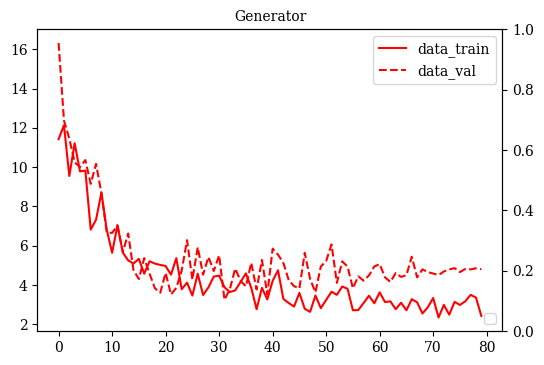

In [27]:
plot_metrics(net.running_metrics_encoder, title='Generator')

## Inference

Structure of data, d:
```0 - syn input
1 - syn low
2 - syn ulow
3 - velocity model
4 - field input
5 - field low
6 - filed ulow
7 - velocity model (zeros)```

# Synthetic data

In [28]:
ls_orig = dc[1].copy()
hs_true = dc[-2].copy()
print(hs_true.shape)
_, ls_pred, us_pred = net.predict(hs_true)

(1, 324, 376)


## FK and TX domains

1081.2861 1312.2893


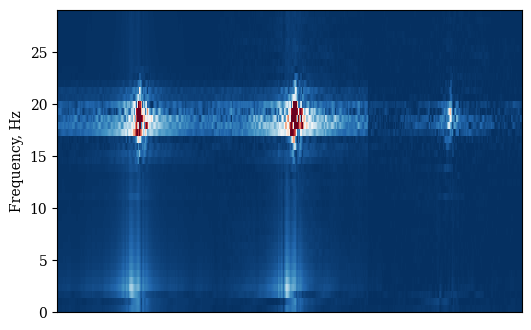

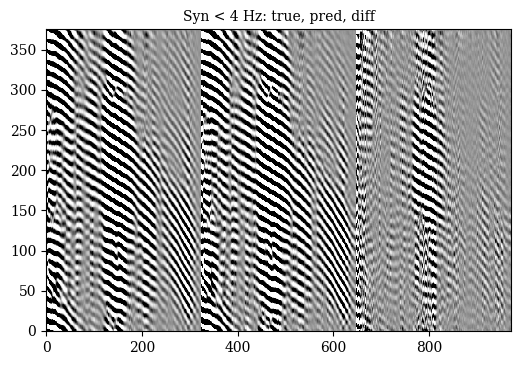

In [29]:
nt_clip=None
vlim_f = {'vmin': -15, 'vmax': 15}
vlim_2f = {'vmin': -0.125, 'vmax': 0.125}
fhp = 0.5
fedge = par['fedge']
dt_net = dt

ls_true = dc[-1].copy()
lst = ls_true[0,...]; ls = ls_pred[0,0,...]
print(lst.max(), ls.max())
lst = ld.bandpass(lst, fs=1/dt_net, flo=fhp, btype='high')
ls = ld.bandpass(ls, fs=1/dt_net, flo=fhp, btype='high')

# vis.plot_wiggles([lst[:, :nt_clip], ls[:, :nt_clip]], n=5)

lst_fk, ls_fk = [vis.get_spectrum2(v, dt=dt_net, fmax=7)[0] for v in [lst, ls]]
vis.plot_spectrum2([lst_fk, ls_fk, np.abs(lst_fk-ls_fk)], plot_only=True, pclip=0.25, dt=dt_net)

vis.plot_shot(np.concatenate([lst, ls, lst - ls]), colorbar=False, **vlim_f,
              title=f'Syn < {_max_freq} Hz: true, pred, diff')

## Tracewise NRMS and linear correlation

(1, 324, 376)


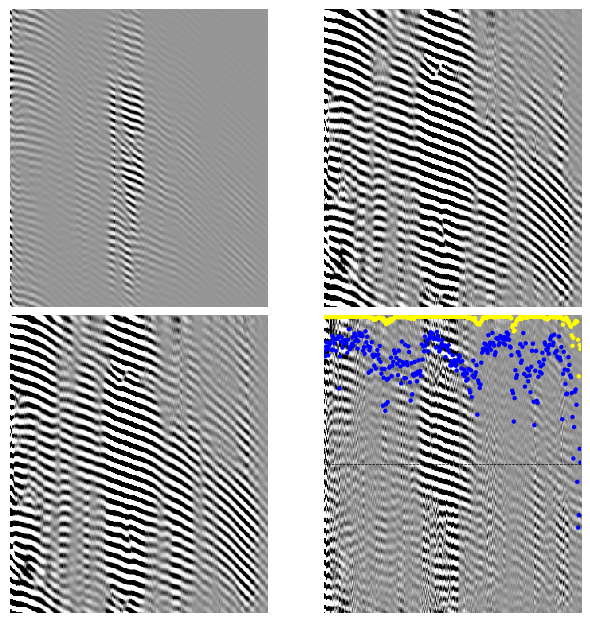

In [30]:
lim=16
ls_true = dc[-1].copy()
print(ls_true.shape)
vis.imgrid(hs_true[0,...], lst, [ls], diff_of_diff=False, figsize=(8,8), 
           vmin=-lim, vmax=lim, scatter_size=10)

## Reverse transformation

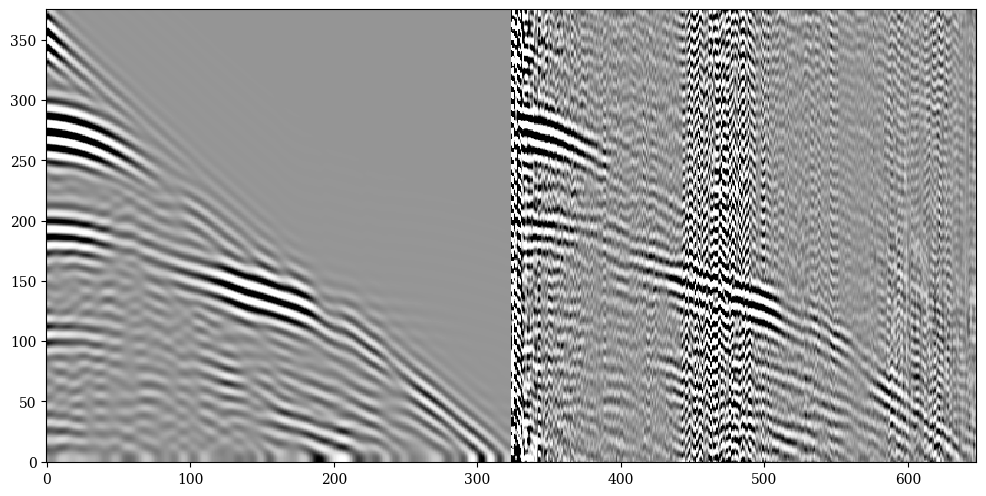

In [31]:
lsi = backward(ls_pred, reference_trace_target, gacorr_lo_f)
vis.plot_shot(np.concatenate([ls_orig, lsi], 1), **_par_shot_auto)

# Field data

In [32]:
hf_true = df[-2].copy()
lf_orig = df[5].copy()
lf_true = df[-1].copy()
print(hf_true.shape, hf_true.max())
_, lf_pred, uf_pred = net.predict(hf_true)

(1, 324, 376) 52.314766


## FK and TX domains

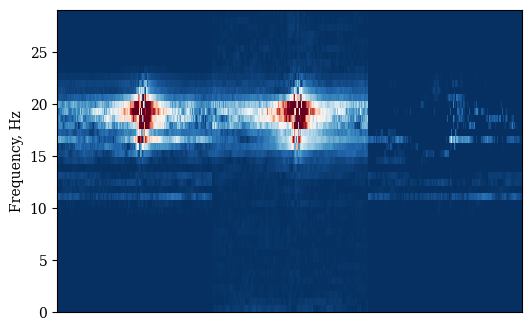

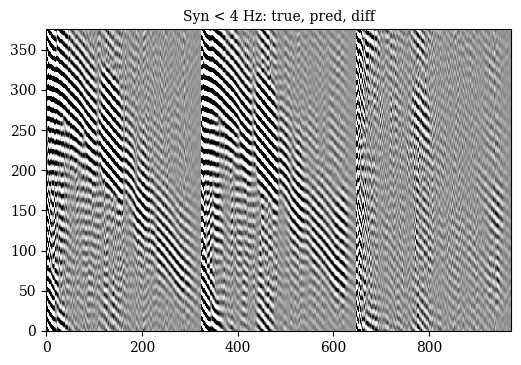

In [33]:
lf = lf_pred.copy()[0, 0,...].astype(np.float32)
lft = lf_true.copy()[0,...]
# lft, lf = [ld.bandpass(v, fhi=2.5, dt=dt_net, btype='low') for v in [lft, lf]]
lft_fk, lf_fk = [vis.get_spectrum2(v, dt=dt_net, fmax=7)[0] for v in [lft, lf]]
vis.plot_spectrum2([lft_fk, lf_fk, lft_fk-lf_fk], plot_only=True, pclip=0.25, dt=dt_net)
vis.plot_shot(np.concatenate([lft, lf, lft - lf]), colorbar=False, **vlim_f,
              title=f'Syn < {_max_freq} Hz: true, pred, diff')
# vis.plot_spectra_dict({'known': lft, 'pred': lf}, dt_net, fmax=fedge)

## Tracewise NRMS and linear correlation

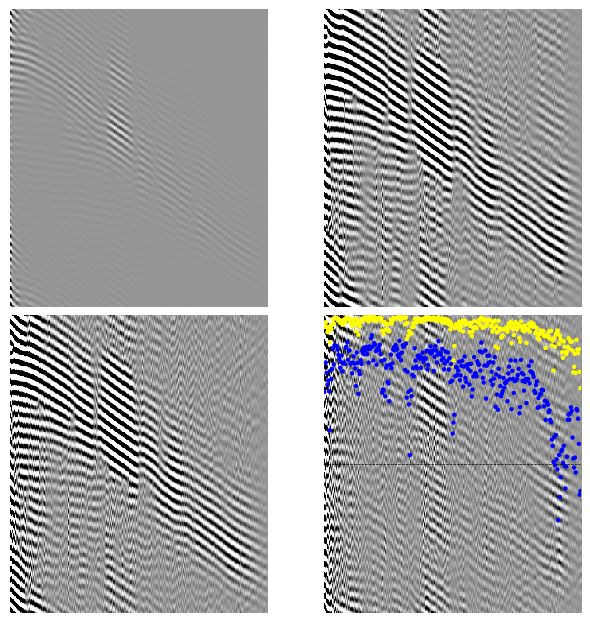

In [34]:
lim=16
# importlib.reload(vis)
vis.imgrid(hf_true[0,...], lft, [lf], diff_of_diff=False, figsize=(8,8), 
           vmin=-lim, vmax=lim, scatter_size=10)

## Reverse transformation

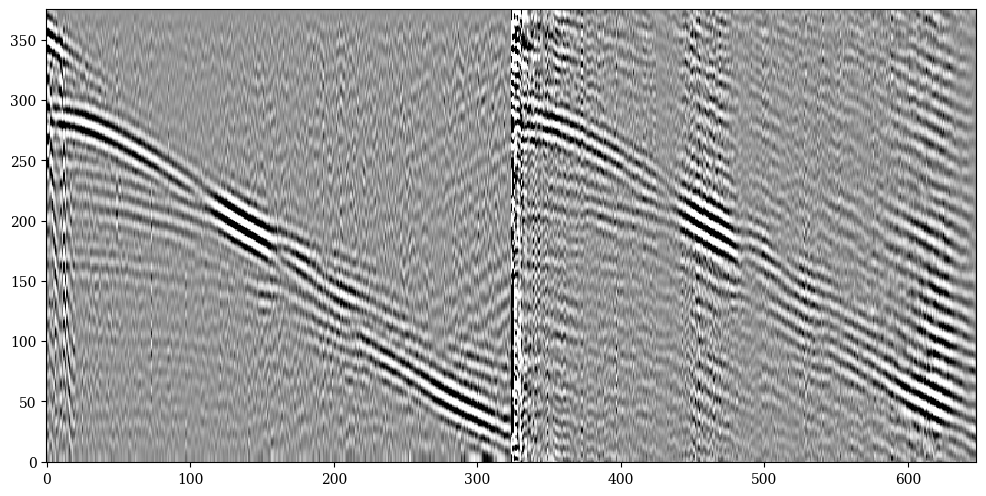

In [107]:
lfi = backward(lf, reference_trace_target_f, gacorr_lo)
vis.plot_shot(np.concatenate([lf_orig, lfi], 1), **_par_shot_auto)